In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
warnings.simplefilter('ignore')


plt.style.use('ggplot')

c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
ocean_discord['message_count'] = 1


In [3]:
import re
reporting_channel = 'Ocean Protocol - GENERAL - 🚨︱report-scammers [912281243012460594]'
reporting_messages = ocean_discord[ocean_discord['Channel'] == reporting_channel]
# Extract usernames mentioned in the messages
reported_users = []
for content in reporting_messages['Content']:
    content = str(content)
    words = ['scammer', 'scam', 'spam']
    for word in words:
        if word in content.lower():
            # Extract usernames preceded by '@' using regular expressions
            users_mentioned = re.findall(r'@(\w+)', content)
            reported_users.extend(users_mentioned)

reported_users = list(set(reported_users))

spam_keywords = ['free', 'win', 'claim', 'discount', 'limited', 'offer', 'act now', 'giveaway', 'airdrop', 'pump']

ocean_discord['Is_Spam'] = 0

# Iterate over each scammer in the reported_users list
for scammer in reported_users:
    # Check if the 'Author' column contains the scammer's username
    ocean_discord.loc[ocean_discord['Author'].str.contains(scammer), 'Is_Spam'] = 1


# Iterate over each message content in the 'Content' column
for content in ocean_discord['Content']:
    # Convert content to lowercase to perform case-insensitive matching
    content_lower = str(content).lower()
    # Iterate over each spam keyword
    for word in spam_keywords:
        # Check if the keyword is in the lowercased content
        if word in content_lower.split(' '):
            # Set 'Is_Spam' to 1 if any keyword is found
            ocean_discord.loc[ocean_discord['Content'] == content, 'Is_Spam'] = 1
            # Break the inner loop if a keyword is found in the current message
            break

ocean_discord.loc[ocean_discord['Author'].str.contains('OceanGPT#0740'), 'Is_Spam'] = 0

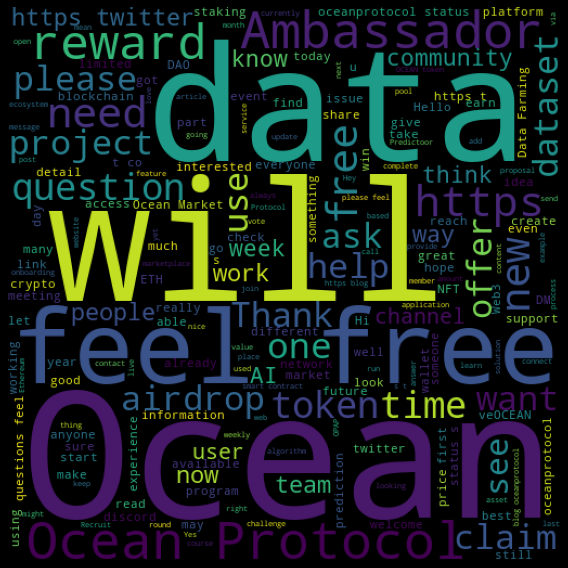

In [4]:
from wordcloud import WordCloud
 
ocean_discord['Content'] = ocean_discord['Content'].fillna('')

scam_words = ''.join(list(ocean_discord[ocean_discord['Is_Spam']==1]['Content']))
scam_words = scam_words.replace('Server', ' ')
scam_words = scam_words.replace('server', ' ')
scam_words = scam_words.replace('Joined', ' ')
scam_wc = WordCloud(width=512, height=512).generate(scam_words)

plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(scam_wc)
plt.axis('off')
plt.tight_layout()
plt.show()


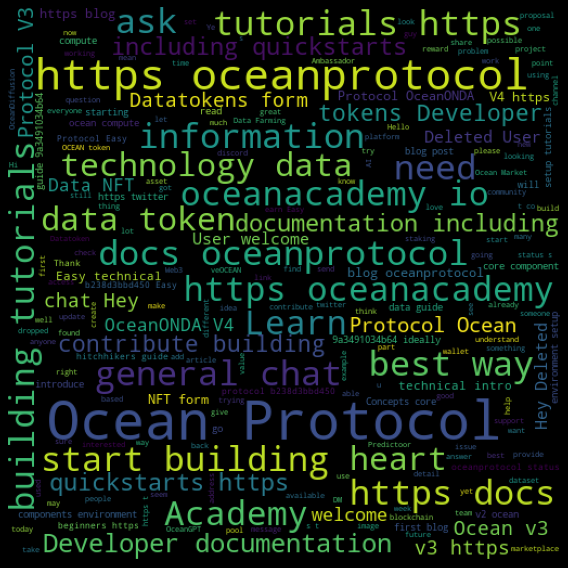

In [5]:

ocean_discord['Content'] = ocean_discord['Content'].fillna('')

scam_words = ''.join(list(ocean_discord[ocean_discord['Is_Spam']==0]['Content']))
scam_words = scam_words.replace('Server', ' ')
scam_words = scam_words.replace('server', ' ')
scam_words = scam_words.replace('Joined', ' ')
scam_wc = WordCloud(width=512, height=512).generate(scam_words)

plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(scam_wc)
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Tokenizing text
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words= set(stopwords.words('english'))
def clean_content(content):
    content = content.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(content.lower())  # Convert content to lowercase before tokenization
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return words

In [7]:
# Vectorize content

vectorization =  CountVectorizer(analyzer = clean_content)
X = vectorization.fit(ocean_discord['Content'])
X_transform = X.transform(ocean_discord['Content'])

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorization = TfidfVectorizer(analyzer=clean_content)  # Adjust max_features as needed
#X = vectorization.fit(ocean_discord['Content'])
#X_transform = X.transform(ocean_discord['Content'])

In [8]:
# TF-IDF

tfidf_transformer = TfidfTransformer().fit(X_transform)
X_tfidf = tfidf_transformer.transform(X_transform)
print(X_tfidf.shape)

(84754, 32633)


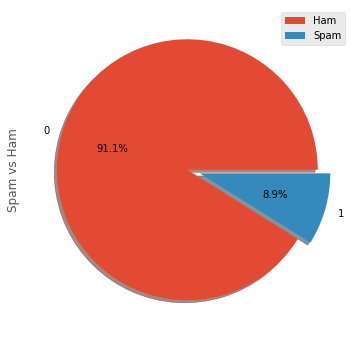

In [9]:
ocean_discord["Is_Spam"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, ocean_discord['Is_Spam'], test_size=0.2, random_state=42)

class_weights = {0: 1, 1: 10} 
clf = SVC(kernel='rbf', class_weight=class_weights)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [11]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[13885  1577]
 [  312  1177]]
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     15462
           1       0.43      0.79      0.55      1489

    accuracy                           0.89     16951
   macro avg       0.70      0.84      0.75     16951
weighted avg       0.93      0.89      0.90     16951



              precision    recall  f1-score   support

           0       0.98      0.90      0.94     15462
           1       0.43      0.79      0.56      1489

    accuracy                           0.89     16951
   macro avg       0.70      0.84      0.75     16951
weighted avg       0.93      0.89      0.90     16951



In [34]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'class_weight': [{0: 1, 1: 10}]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train SVC with best parameters
best_clf = SVC(kernel='rbf', **best_params)
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define keywords indicative of technical issues
technical_keywords = [
    'error', 'issue', 'problem', 'bug', 'crash', 'failure', 'warning', 'exception', 'malfunction', 'breakdown',
    'connection', 'network', 'internet', 'server', 'offline', 'timeout', 'latency', 'bandwidth', 'firewall',
    'slow', 'lag', 'freeze', 'hang', 'delay', 'bottleneck', 'overload',
    'display', 'layout', 'formatting', 'alignment', 'rendering', 'appearance', 'visibility',
    'feature', 'function', 'capability', 'behavior', 'operation', 'functionality',
    'compatibility', 'interoperability', 'integration', 'version', 'update', 'upgrade',
    'security', 'vulnerability', 'breach', 'exploit', 'unauthorized', 'permission',
    'memory', 'CPU', 'disk', 'storage', 'resource', 'utilization',
    'log', 'monitoring', 'analytics', 'metrics', 'audit', 'trace',
    'API', 'third-party', 'external service', 'integration'
]
# Stemmer initialization
stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))
additional_stop_words = {'data', 'ocean', 'protocol', 
                         "'s", '@', "'", '`', '.',
                          'use', '?', '!', ':',
                          'use', 'http', 'discord',
                          'join'}
stop_words.update(additional_stop_words)
# Function to stem and tokenize content
def stem_and_tokenize(content):
    content = content.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(content.lower())  # Convert content to lowercase before tokenization
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return stemmed_words

# Stem and tokenize content
ocean_discord['Stemmed_Content'] = ocean_discord['Content'].apply(stem_and_tokenize)
stemmed_technical_keywords = [stemmer.stem(word) for word in technical_keywords]


technical_messages = ocean_discord[ocean_discord['Stemmed_Content'].apply(lambda x: any(word in x for word in stemmed_technical_keywords))]

system_words_stemmed = [stemmer.stem(word) for word in ['system', 'server', 'software']]
# Categorize identified issues based on potential sources
user_related = technical_messages[technical_messages['Stemmed_Content'].apply(lambda x: any(word in x for word in [stemmer.stem('user')]))]
system_related = technical_messages[technical_messages['Stemmed_Content'].apply(lambda x: any(word in x for word in system_words_stemmed))]
external_factors = technical_messages[~technical_messages.index.isin(user_related.index) & ~technical_messages.index.isin(system_related.index)]

# Function to count occurrences of words
def count_words(content):
    word_count = {}
    for word in content:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1
    return word_count

# Count occurrences of words for each category
user_word_counts = user_related['Stemmed_Content'].apply(count_words)
system_word_counts = system_related['Stemmed_Content'].apply(count_words)
external_word_counts = external_factors['Stemmed_Content'].apply(count_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


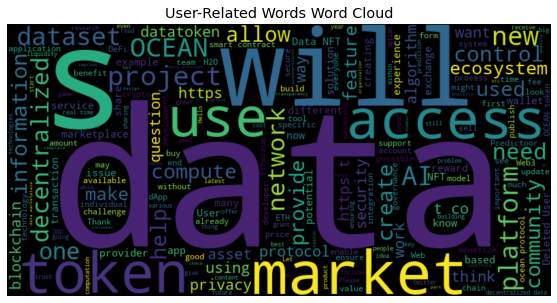

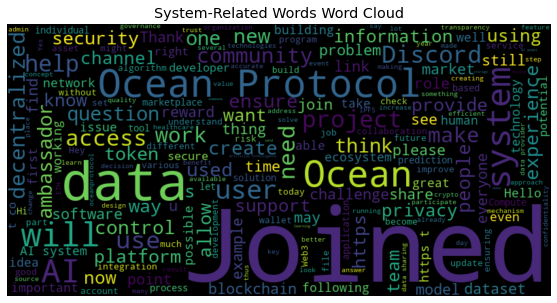

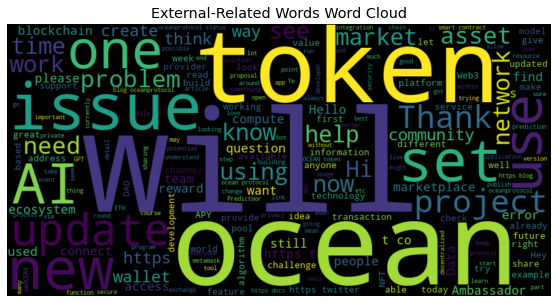

In [35]:
from wordcloud import WordCloud

# Generate word cloud for user-related words
user_words = ' '.join(user_related['Content'])
user_words = user_words.replace('user', ' ')
user_words = user_words.replace('Ocean', ' ')
user_words = user_words.replace('Protocol', ' ')
user_wordcloud = WordCloud(width=800, height=400).generate(user_words)
plt.figure(figsize=(10, 5))
plt.imshow(user_wordcloud, interpolation='bilinear')
plt.title('User-Related Words Word Cloud')
plt.axis('off')
plt.show()

# Similarly, generate word clouds for system-related and external factors words
system_words = ' '.join(system_related['Content'])
system_words = system_words.replace('server', ' ')
system_words = system_words.replace('joinded', ' ')
#user_words = user_words.replace('Protocol', ' ')
system_wordcloud = WordCloud(width=800, height=400).generate(system_words)
plt.figure(figsize=(10, 5))
plt.imshow(system_wordcloud, interpolation='bilinear')
plt.title('System-Related Words Word Cloud')
plt.axis('off')
plt.show()


ext_words = ' '.join(external_factors['Content'])
ext_words = ext_words.replace('data', ' ')
ext_words = ext_words.replace('Ocean', ' ')
ext_words = ext_words.replace('Protocol', ' ')
ext_wordcloud = WordCloud(width=800, height=400).generate(ext_words)
plt.figure(figsize=(10, 5))
plt.imshow(ext_wordcloud, interpolation='bilinear')
plt.title('External-Related Words Word Cloud')
plt.axis('off')
plt.show()
